# Modelando la dinámica del mercado

Queremos modelar y predecir ciertas dinámicas del mercado a partir de la evolución temporal del precio de las acciones de Apple (AAPL).

Si graficamos el precio de una acción a lo largo del tiempo, obtenemos una serie temporal unidimensional: una línea en forma de zigzag que refleja subidas y bajadas. Desde el punto de vista topológico, una curva 1D no tiene agujeros ni estructura geométrica compleja, por lo que aporta poca información para un análisis topológico.

Para poder aplicar análisis topológico de datos (TDA), utilizamos el embedding de Takens, que permite reconstruir la dinámica subyacente del sistema en un espacio de mayor dimensión. En lugar de considerar solo el precio de hoy, construimos vectores que incluyen el precio de hoy, de ayer, de anteayer, etc. Por ejemplo, cada día queda representado por un punto de la forma

$$
(p_t, p_{t-1}, p_{t-2})
$$

lo que genera una representación en $\mathbb{R}^3$.

Al repetir este procedimiento para toda la serie temporal, la curva original “plana” se enrolla sobre sí misma, formando una nube de puntos en el espacio de fases que captura la geometría de la dinámica del mercado.
Una vez reconstruido este espacio de fases, podemos calcular diagramas de persistencia, analizar características topológicas (como componentes conexas y ciclos), y comparar distintas ventanas temporales mediante distancias topológicas, lo que nos permite estudiar cambios de régimen y patrones dinámicos del mercado.

# Algunas definiciones útiles

## 1. ¿Qué es la Volatilidad?

La volatilidad mide la intensidad y la rapidez con la que cambia el precio de un activo. No importa si el precio sube o baja, sino cuán grandes y abruptos son esos movimientos.

- Volatilidad baja:  
  Los precios cambian de manera suave y gradual (por ejemplo, hoy +0.1%, mañana −0.1%).  
  Desde el punto de vista de TDA, esto produce una nube de puntos compacta y concentrada, ya que la dinámica es estable y los estados del sistema son similares entre sí.

- Volatilidad alta:  
  Los precios presentan saltos bruscos (por ejemplo, hoy +5%, mañana −7%).  
  En TDA, la nube de puntos se expande y se dispersa, reflejando una dinámica inestable y altamente variable.

Durante episodios de alta volatilidad, los cambios extremos de precio hacen que los puntos del espacio de fases se separen fuertemente. Vamos a ver que esto se traduce en un aumento marcado de $H_0$: aparecen muchas componentes conexas porque los “volantazos” del precio rompen la continuidad de la dinámica.

---


## 2. ¿Qué es la Tendencia? (La “dirección” del mercado)

La tendencia describe la dirección general del movimiento del precio a lo largo del tiempo. A diferencia de la volatilidad, ignora las oscilaciones diarias pequeñas y se centra en el comportamiento global.

Existen tres tipos principales:

- Tendencia alcista (Bullish):  
  El precio muestra máximos y mínimos cada vez más altos.

- Tendencia bajista (Bearish):  
  El precio cae de forma sostenida, con máximos y mínimos decrecientes.

- Tendencia lateral (Rango):  
  El precio oscila dentro de un canal aproximadamente horizontal, sin una dirección clara.

Una tendencia lateral genera ciclos recurrentes: el precio sube y baja, pero tiende a volver a niveles similares. Vamos a ver que en el espacio de fases, esto da lugar a estructuras cerradas, que se manifiestan como clases persistentes en $H_1$.
  
Una tendencia bajista fuerte, como en una caída abrupta del mercado, se parece más a una trayectoria casi monótona hacia abajo. Vamos a ver que al no haber retorno a estados previos, no se forman ciclos, por lo que las clases en $H_1$ mueren.


# Instalación de librerías

In [ ]:
!pip install yfinance ripser persim matplotlib pandas --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from persim import bottleneck, wasserstein, plot_diagrams
from ripser import ripser

import yfinance as yf
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Cargando los datos

Empezamos cargando los datos de las acciones de APPLE. Nos quedamos con los valores del precio de cierre de las acciones.

[*********************100%***********************]  1 of 1 completed


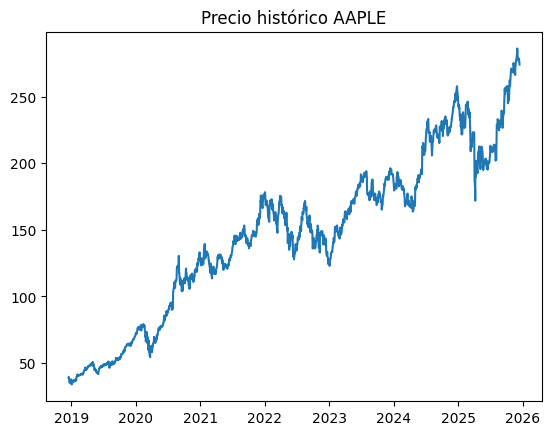

In [ ]:
def load_stock(symbol="AAPL", period="2y"): #acciones de APPLE
    data = yf.download(symbol, period=period)
    data = data[['Close']] #me quedo solo la columna CLOSE: precio de cierre (el precio final al que se negoció cada acción cada día)
    return data

stock = load_stock("AAPL", "7y")
plt.plot(stock.Close) #precios de cierre a lo largo del tiempo de las acciones de APPLE
plt.title("Precio histórico AAPLE")
plt.show()
#El eje y es el precio en dólares por acción.

# Embedding de Takens

El embedding toma una serie temporal unidimensional (1D) y la transforma en una colección de vectores multidimensionales.

Los sistemas reales, como el mercado financiero, tienen dinámicas internas complejas que no pueden describirse adecuadamente en una sola dimensión. Por eso utilizamos embedding de Takens para reconstruir la dinámica del sistema en un espacio de mayor dimensión, el espacio de fases. El resultado es una nube de puntos que representa la trayectoria del sistema en el tiempo.

Esta nube de puntos es la entrada que utiliza Ripser para calcular el diagrama de persistencia. En este enfoque, TDA no analiza directamente los valores del precio, sino la geometría de la trayectoria que esos precios describen en el espacio de fases.




## ¿Cómo elegir los valores de dim y delay?
La dimensión del embedding y el retardo temporal (delay) determinan la forma geométrica de la nube de puntos que Ripser va a analizar:

- Si la reconstrucción es adecuada aparecen estructuras topológicas reales, como ciclos y agujeros persistentes $H_1$.

- Si la reconstrucción es deficiente la geometría se distorsiona y Ripser solo detecta ruido, sin estructuras persistentes significativas.
---
La dimensión del embedding determina la dimensión del espacio de fases en el que se reconstruye la dinámica del sistema.

- Si la dimensión es demasiado baja, la dinámica queda proyectada y se pierde estructura.
- Si la dimensión es demasiado alta, se introduce ruido innecesario y la geometría se vuelve difusa.

Algunos ejemplos típicos son:

- `dim = 2` → la dinámica se proyecta en un plano 2D.  
- `dim = 3` → la dinámica se reconstruye en un espacio 3D.  
- `dim = 5` o `dim = 6` → dimensiones comúnmente usadas en señales complejas (ECG, clima, mercados financieros, etc.).

En nuestro caso, como trabajamos con una sola acción, no es necesario usar dimensiones muy altas. Con 3D o 4D es suficiente para capturar la dinámica relevante del mercado sin introducir complejidad artificial.

En este análisis fijamos `dim = 3`.

---

El delay (retardo temporal) debe elegirse de modo que cada coordenada del vector de embedding aporte información nueva y no redundante.

- Si el delay es demasiado chico, las coordenadas están fuertemente correlacionadas. Los puntos quedan muy cerca entre sí, la nube se “aplasta” y Ripser ve algo cercano a una línea recta.
- Si el delay es demasiado grande, las coordenadas se vuelven casi independientes. La nube queda excesivamente dispersa y TDA detecta principalmente ruido, sin estructuras persistentes.


En este análisis fijamos `delay = 2`, lo que permite estudiar las relaciones inmediatas entre ayer, hoy y mañana, capturando la dinámica local del precio.

In [ ]:
def takens_embedding(signal, dim=3, delay=2):
  #dim es cuántas copias de la serie temporal "atrasada" voy a usar para reconstruir el espacio de fase
  #el delay es cuánto me corro en el tiempo para formar las coordenadas
    signal = np.ravel(signal)    #asegura que la señal sea un vector 1D
    n = len(signal) - (dim - 1) * delay
    embedded = np.zeros((n, dim))
    for i in range(n):
        embedded[i] = signal[i:i + dim * delay:delay]
    return embedded

# Cálculo de persistencia

## ¿Qué es $H_0$? (componentes conexas y regímenes de comportamiento)

En topología, $H_0$ cuenta el número de componentes conexas, es decir, cuántos conjuntos de puntos permanecen separados entre sí a una cierta escala. Desde un punto de vista geométrico, describe la presencia de clusters o regímenes distintos de comportamiento dentro de los datos.

En el contexto financiero, $H_0$ mide la separación entre estados dinámicos del mercado en el espacio de fases. Cada componente conexa puede interpretarse como un régimen local de comportamiento.

En este análisis se trabaja con una sola acción y se utilizan log-retornos del precio (se explica esto cuando elegimos las ventanas). En este contexto, los estados del sistema están dominados principalmente por el valor del precio y sus variaciones inmediatas. Por esta razón, la aparición de un valor elevado de $H_0$ lo interpretamos como rupturas locales en la continuidad de la dinámica del precio.

Un aumento abrupto de $H_0$ indica que ciertos puntos del embedding quedan aislados del resto, lo cual ocurre cuando el precio experimenta movimientos violentos que lo separan del comportamiento reciente. En otras palabras, los precios dejan de conectarse de manera suave en el espacio de fases.

Entonces:
- Un $H_0$ bajo indica que los precios evolucionan de forma continua y conectada.
- Un $H_0$ alto indica la presencia de saltos bruscos y discontinuidades en la evolución del precio.

---

## ¿Qué es $H_1$? (ciclos, bucles y estructura de la volatilidad)

En topología, $H_1$ cuenta la presencia de agujeros o ciclos en la nube de puntos.

En finanzas, $H_1$ captura la recurrencia y la estructura interna de la volatilidad. De manera intuitiva, $H_1$ indica si el precio queda atrapado en un comportamiento repetitivo o cíclico, en lugar de seguir una trayectoria puramente direccional. Para interpretar correctamente $H_1$, es necesario analizar dos aspectos fundamentales, la persistencia y el momento de nacimiento de los ciclos.

### Persistencia (importancia del ciclo)

La importancia de un ciclo es proporcional a su distancia a la diagonal en el diagrama de persistencia.

- Puntos cercanos a la diagonal (ruido):  
  El ciclo nace y muere casi instantáneamente.  
  Interpretación: ruido de mercado, micro-volatilidad o fluctuaciones aleatorias sin estructura.

- Puntos alejados de la diagonal (estructura real):  
  El ciclo persiste a lo largo de un amplio rango de escalas.  
  Interpretación: existe un patrón recurrente fuerte. El precio sube, baja y vuelve a subir siguiendo una geometría estable en el espacio de fases.

### Momento de nacimiento del ciclo

El eje horizontal del diagrama indica la escala a la cual aparece el ciclo. En datos financieros normalizados, esta escala se relaciona directamente con la amplitud de la volatilidad.

- Nacimiento temprano (aproximadamente entre 0.0 y 0.5):  
  Ciclos pequeños y compactos.  
  Interpretación: oscilaciones de baja amplitud. El mercado presenta movimientos suaves, característicos de períodos de calma.

- Nacimiento tardío (aproximadamente entre 1.0 y 2.0):  
  Ciclos amplios y extendidos.  
  Interpretación: oscilaciones de gran amplitud. Para que el ciclo aparezca, es necesario conectar puntos muy alejados entre sí, lo que indica movimientos profundos de subida y bajada.


In [ ]:
def compute_persistence(point_cloud, maxdim=2):
    result = ripser(point_cloud, maxdim=maxdim)
    return result['dgms']

#Distancias
## Distancia Blottleneck
La distancia Bottleneck es una medida de similitud topológica entre dos diagramas de persistencia: cuanto más pequeña es, más parecidas son las estructuras topológicas de las dos ventanas temporales.

Desde el punto de vista geométrico, la distancia Bottleneck mide el peor cambio topológico entre dos diagramas. Es decir, se fija únicamente en la mayor discrepancia individual entre las características topológicas de ambas ventanas.

En particular, cuando se aplica a $H_1$ compara los ciclos de dos diagramas, busca el ciclo cuya diferencia sea máxima e ignora el resto de las diferencias.

Responde a la pregunta ¿cuál es el cambio topológico más extremo que ocurrió entre estas dos ventanas?

---
## Distancia Wassertein
La distancia Wasserstein, en cambio, captura cambios globales y distribuidos.

En lugar de enfocarse en un único punto, mide el costo total necesario para transformar un diagrama en el otro. Esto se interpreta como la suma de los desplazamientos de todos los puntos del diagrama (ciclos y ruido incluidos) hasta hacerlos coincidir.

Responde a la pregunta ¿cuánto cambió en conjunto la estructura topológica del sistema?


In [ ]:
def compute_distances(dgm1, dgm2):
    # Filtrar puntos infinitos (esencial para H1)
    d1 = dgm1[np.isfinite(dgm1[:, 1])]
    d2 = dgm2[np.isfinite(dgm2[:, 1])]

    # Usamos la librería persim directamente
    d_bottle = bottleneck(d1, d2)
    d_wass = wasserstein(d1, d2)

    return d_bottle, d_wass

#Elección de ventanas

El objetivo del uso de ventanas temporales es dividir la serie temporal extensa en segmentos más pequeños para analizar los regímenes locales del mercado.

Cada ventana corresponde a un intervalo de tiempo en el cual se asume que la dinámica subyacente del mercado es aproximadamente constante. De este modo, distintas ventanas exhiben regímenes dinámicos diferentes, aun cuando pertenecen al mismo activo financiero.


## ¿Qué criterio usar para reconstruir la dinámica?

Una primera opción es discretizar la serie en términos binarios:  `+1` si el precio sube y `-1` si baja. Sin embargo, este enfoque no es correcto para análisis con TDA. Al conservar únicamente la dirección, se pierde toda la información sobre la magnitud del movimiento. Por ejemplo, una subida del 0.1% y una del 10% serían indistinguibles bajo este esquema, pese a que generan geometrías muy distintas en el espacio de fases. Desde el punto de vista topológico, los movimientos de gran magnitud “estiran” la nube de puntos y pueden generar bucles persistentes, mientras que fluctuaciones pequeñas producen estructuras difusas.

---

La solución parece ser entonces usar los precios para discretizar la serie. Sin embargo, el problema de usar los precios directamente es que no son estacionarios. Por ejemplo, si una acción pasa de 100 a 200, la nube de puntos asociada a la reconstrucción del espacio de fases se “estira” artificialmente. Este estiramiento modifica las distancias entre puntos sin reflejar un cambio real en la dinámica del sistema.

---

Para evitar este problema, utilizamos log-retornos, definidos como

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right),
$$

donde $P_t$ es el precio en el instante $t$.

Esta transformación vuelve a la serie cuasi-estacionaria, estabiliza la varianza y elimina los efectos puramente multiplicativos del precio. Esto es crucial para poder asumir que la dinámica del sistema permanece constante dentro de cada ventana temporal.

Otra ventaja de los log-retornos es la simetría. Un movimiento de $100 \to 50$ (caída del 50%) y uno de $50 \to 100$ tienen igual magnitud y signo opuesto. Esta simetría permite que las trayectorias reconstruidas en el espacio de fases sean más isotrópicas, evitando deformaciones elípticas artificiales. Como resultado, los ciclos detectados por TDA tienden a ser más estables y geométricamente significativos.


Al analizar trayectorias de log-retornos continuos, el TDA puede detectar cambios de régimen antes de que estos sean evidentes en gráficos tradicionales de precios. En particular, antes de una caída abrupta, la dinámica suele cambiar sutilmente: la volatilidad comienza a oscilar de manera más estructurada. Este fenómeno no siempre es visible para el ojo humano, pero se manifiesta claramente como un cambio en la homología persistente.


In [ ]:
def load_financial_windows(symbol, period, window_size, step):

    df = yf.download(symbol, period=period, progress=False, auto_adjust=True)
    prices = df['Close'].values.flatten()

    # Log-retornos
    returns = np.diff(np.log(prices[prices > 0]))

    windows = []
    dates = [] # Para saber cuándo termina cada ventana

    # Iteramos
    for start in range(0, len(returns), step):
        end = start + window_size

        # Si la ventana es más chica, se descarta.
        if end > len(returns):
            break

        w = returns[start : end]

        # Normalización Z-Score
        if np.std(w) > 0:
            w = (w - np.mean(w)) / np.std(w)
            windows.append(w)
            # Guardamos la fecha del final de la ventana
            if start + window_size < len(df.index):
                dates.append(df.index[start + window_size])
            else:
                dates.append(df.index[-1])

    print(f" Se generaron {len(windows)} ventanas completas de {window_size} días.")
    return windows, dates

# Un primer experimento

Comenzamos con un experimento sencillo: comparar dos ventanas temporales. La idea es verificar si el TDA puede “ver” una diferencia clara entre un mercado en crisis (crash) y un mercado tranquilo (calma).

In [ ]:
def get_window_data(symbol, start_date, end_date):

    df = yf.download(symbol, start=start_date, end=end_date, progress=False, auto_adjust=True)
    prices = df['Close'].values.flatten()

    # log-retornos
    returns = np.diff(np.log(prices[prices > 0]))

    # normalización Z-Score , para que las ventanas tengan misma escala
    if np.std(returns) > 0:
        returns = (returns - np.mean(returns)) / np.std(returns)

    return returns, df.index[1:] # devuelvo fechas

## Descripción del experimento

Vamos a considerar dos muestras representativas de distintos regímenes de mercado:

- Muestra "Crash" (w1): corresponde al inicio de la pandemia (febrero–junio de 2020), un período caracterizado por una fuerte caída del mercado y alta volatilidad.

- Muestra "Calma" (w2): corresponde a un período estable (enero–mayo de 2021), en el cual el mercado presenta subas sostenidas y baja volatilidad.


---

### Estandarización de la longitud de las ventanas

Un problema natural es que ambos períodos pueden tener distinta cantidad de días hábiles. Por ejemplo, la muestra Crash puede contener 83 días, mientras que la muestra Calma puede contener 85.

Para garantizar una comparación justa, calculamos la longitud mínima entre ambas ventanas y recortamos los dos arreglos para que tengan exactamente la misma cantidad de puntos (días). De este modo, se eliminamos sesgos asociados al tamaño de la muestra.

---

### Embedding de Takens

Construimos el espacio de fases de cada ventana mediante el embedding de Takens.

En el período Calma, los valores sucesivos son similares entre sí. Como consecuencia, la nube de puntos resultante es compacta y concentrada, con una geometría cercana a una elipse o una bola pequeña.

En el período Crash, la dinámica es altamente volátil y caótica. La nube de puntos se expande significativamente, generando trayectorias largas que se alejan del centro.

---

### Cálculo de homología persistente

Sobre cada nube de puntos calculamos la homología persistente:

- $H_0$ (componentes conexas): mide el grado de agrupamiento de los puntos y la cohesión global de la nube.
- $H_1$ (ciclos o bucles): captura la presencia de recurrencias y estructuras cíclicas en la dinámica.

---
### Comparación mediante distancias entre diagramas

Finalmente, comparamos los diagramas de persistencia asociados a $H_0$ y $H_1$ de ambos períodos.

Se utiliza la distancia de Wasserstein, que puede interpretarse como el costo mínimo necesario para transformar el diagrama correspondiente al mercado Crash en el del mercado Calma. Un valor elevado de esta distancia indica que ambos períodos presentan estructuras topológicas fundamentalmente distintas. Esto sugiere que no se trata únicamente de una caída en los precios, sino de un cambio profundo en la dinámica interna del mercado.


   -> Ambas ventanas recortadas a 81 días hábiles.


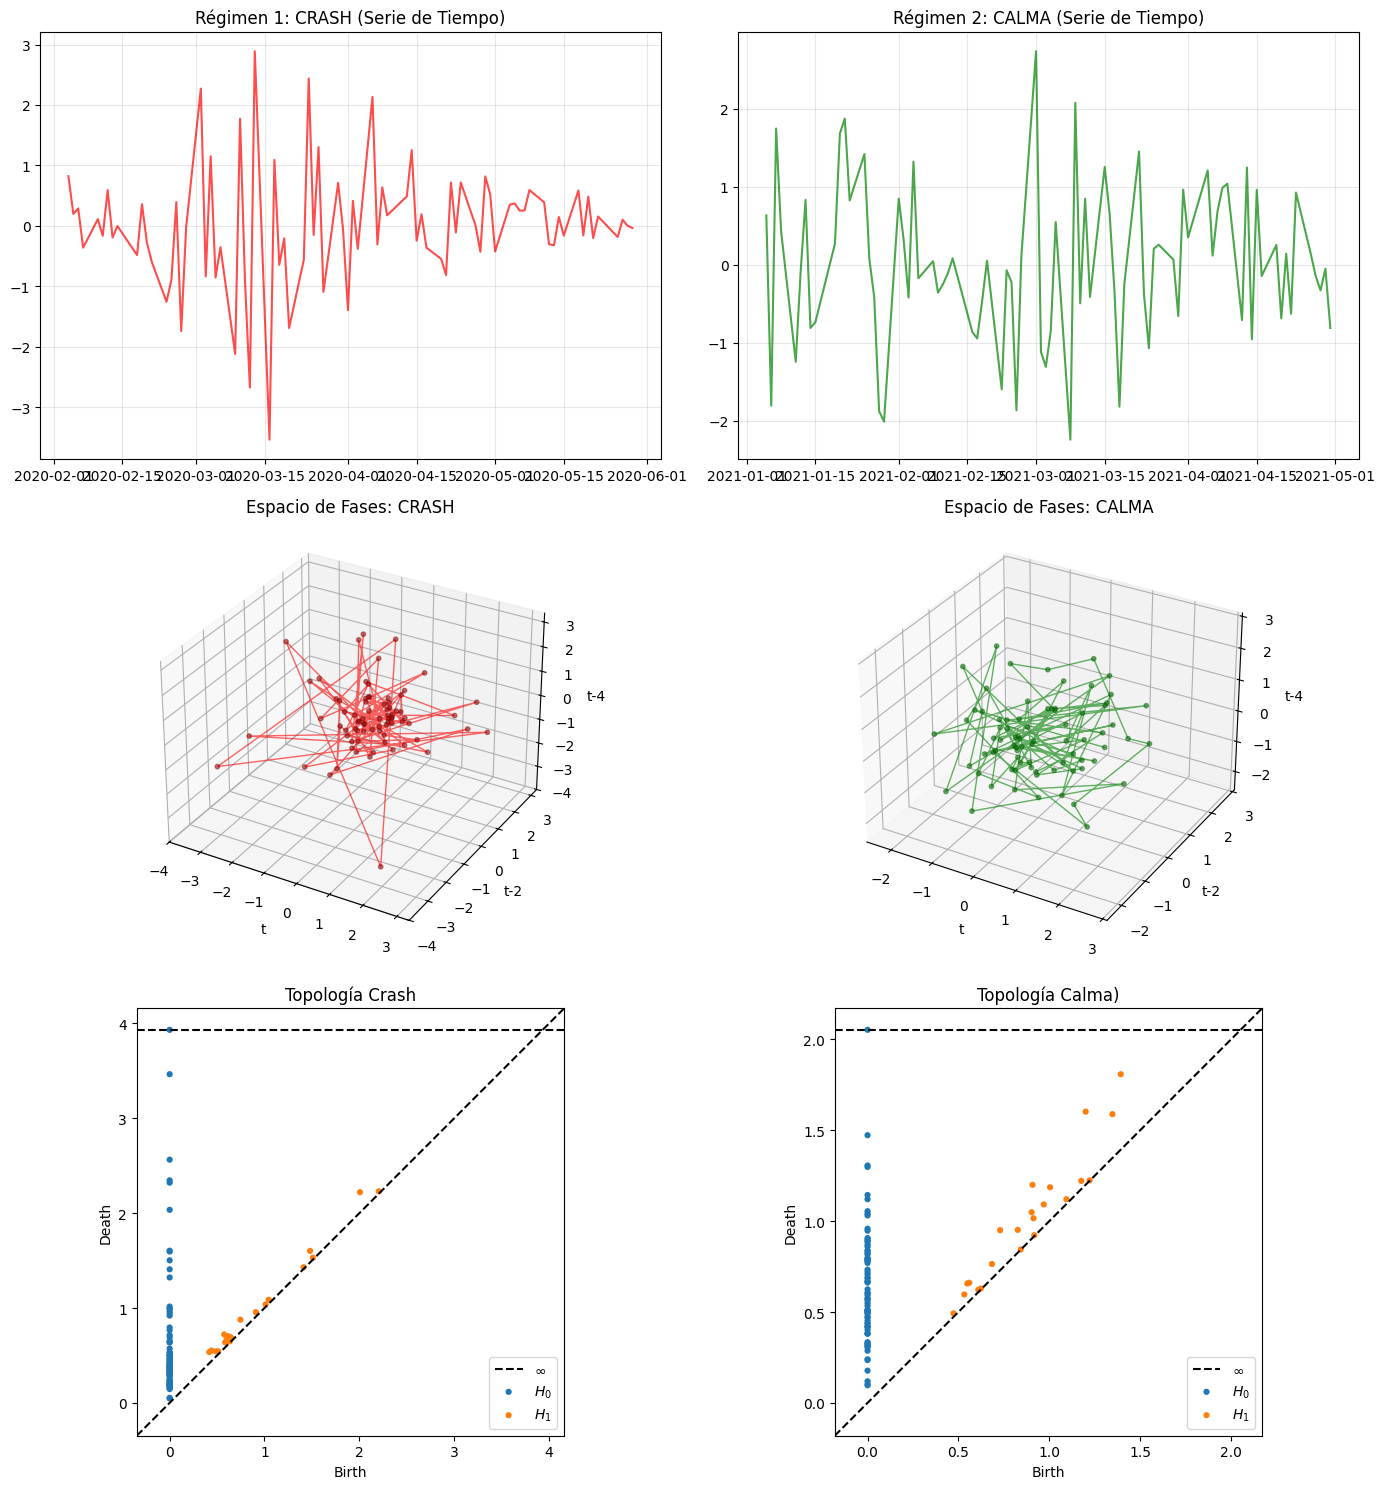


      RESULTADOS DE LA COMPARACIÓN
Distancia Bottleneck (H0): 1.7327
Distancia Wasserstein (H0): 18.3410
Distancia Bottleneck (H1):  0.2062
Distancia Wasserstein (H1): 2.1600
----------------------------------------


In [ ]:
def compare_two_regimes(symbol="AAPL"):

    #Caso 1: COVID (mucha inestabilidad)
    start1, end1 = "2020-02-01", "2020-06-01"

    #Caso 2: mercado tranquilo (estructura estable)
    start2, end2 = "2021-01-01", "2021-05-01"

    w1, dates1 = get_window_data(symbol, start1, end1)
    w2, dates2 = get_window_data(symbol, start2, end2)

    # Ajuste para que tengan exactamente el mismo largo
    min_len = min(len(w1), len(w2))
    w1 = w1[:min_len]
    w2 = w2[:min_len]
    dates1 = dates1[:min_len]
    dates2 = dates2[:min_len]

    print(f"   -> Ambas ventanas recortadas a {min_len} días hábiles.")

    #Cálculo de topología
    DIM = 3
    DELAY = 2

    emb1 = takens_embedding(w1, dim=DIM, delay=DELAY)
    emb2 = takens_embedding(w2, dim=DIM, delay=DELAY)

    dgm1 = compute_persistence(emb1, maxdim=1)
    dgm2 = compute_persistence(emb2, maxdim=1)

    #Distancias
    d_bottle, d_wass = compute_distances(dgm1[1], dgm2[1])
    d_bottle_h0, d_wass_h0 = compute_distances(dgm1[0], dgm2[0])


    fig = plt.figure(figsize=(14, 15))

    # Fila 1: Series de Tiempo
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.plot(dates1, w1, color='red', alpha=0.7)
    ax1.set_title("Régimen 1: CRASH (Serie de Tiempo)")
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(3, 2, 2)
    ax2.plot(dates2, w2, color='green', alpha=0.7)
    ax2.set_title("Régimen 2: CALMA (Serie de Tiempo)")
    ax2.grid(True, alpha=0.3)

    # Fila 2: Espacio de fases 3D
    ax3 = fig.add_subplot(3, 2, 3, projection='3d')
    ax3.plot(emb1[:,0], emb1[:,1], emb1[:,2], color='red', alpha=0.6, lw=1)
    ax3.scatter(emb1[:,0], emb1[:,1], emb1[:,2], color='darkred', s=10, alpha=0.5) # Puntos
    ax3.set_title("Espacio de Fases: CRASH")
    ax3.set_xlabel('t'); ax3.set_ylabel(f't-{DELAY}'); ax3.set_zlabel(f't-{DELAY*2}')

    ax4 = fig.add_subplot(3, 2, 4, projection='3d')
    ax4.plot(emb2[:,0], emb2[:,1], emb2[:,2], color='green', alpha=0.6, lw=1)
    ax4.scatter(emb2[:,0], emb2[:,1], emb2[:,2], color='darkgreen', s=10, alpha=0.5) # Puntos
    ax4.set_title("Espacio de Fases: CALMA")
    ax4.set_xlabel('t'); ax4.set_ylabel(f't-{DELAY}'); ax4.set_zlabel(f't-{DELAY*2}')

    # Fila 3: Diagramas de Persistencia
    ax5 = fig.add_subplot(3, 2, 5)
    plot_diagrams(dgm1, ax=ax5)
    ax5.set_title("Topología Crash")

    ax6 = fig.add_subplot(3, 2, 6)
    plot_diagrams(dgm2, ax=ax6)
    ax6.set_title("Topología Calma)")

    plt.tight_layout()
    plt.show()


    #Conclusión numérica
    print("\n" + "="*40)
    print("      RESULTADOS DE LA COMPARACIÓN")
    print("="*40)
    print(f"Distancia Bottleneck (H0): {d_bottle_h0:.4f}")
    print(f"Distancia Wasserstein (H0): {d_wass_h0:.4f}")
    print(f"Distancia Bottleneck (H1):  {d_bottle:.4f}")
    print(f"Distancia Wasserstein (H1): {d_wass:.4f}")
    print("-" * 40)

compare_two_regimes("AAPL")

### 1. Análisis visual (los gráficos superiores)

Series de tiempo (rojo vs. verde): gracias a la normalización, ambas series oscilan aproximadamente entre −2 y +2.

La curva roja (Crash) presenta picos más agudos y saltos repentinos.

La curva verde (Calma) es más fluida y regular. Sube y baja constantemente alrededor de cero, que actúa como un nivel de equilibrio. La serie no presenta una tendencia explosiva sostenida ni hacia arriba ni hacia abajo. Cuando el precio sube fuertemente un día (pico alto), en los días siguientes tiende a bajar para compensar. En matemáticas financieras, este comportamiento se conoce como reversión a la media. El mercado recibe información, reacciona y luego vuelve hacia un estado de equilibrio.

Aunque a simple vista ambas series parecen similares debido a la normalización, la topología es capaz de detectar diferencias estructurales que el ojo humano no percibe.

---

### 2. Análisis topológico: interpretación de los diagramas de persistencia

El análisis de los diagramas de persistencia permite traducir fenómenos de mercado, como la volatilidad o las tendencias, al lenguaje de la topología algebraica.

#### Homología de dimensión 0 ($H_0$)


- Topología asociada a Calma (muerte baja, aproximadamente menor que 1.0–1.5):

    La mayoría de los puntos mueren rápidamente. Esto indica que la nube de puntos es compacta y que basta aumentar levemente el radio de conexión para que todos los puntos queden conectados. En términos financieros, los precios de hoy están muy cerca de los de ayer, sin saltos bruscos.

- Topología asociada a Crash (muerte alta, valores cercanos a 4):

    Se observan numerosos puntos con valores de muerte elevados. Existen componentes conexas que sobreviven durante un amplio rango de escalas. Esto indica la presencia de saltos violentos que generan puntos aislados muy alejados del resto de la nube.

    Por ejemplo, si el precio cierra en 150 y al día siguiente abre en 135 debido a un evento de pánico, ese punto queda geométricamente aislado. Para conectarlo con el comportamiento reciente, el algoritmo debe extender considerablemente el radio de conexión. Este estiramiento se refleja como puntos con valores altos en el eje vertical del diagrama de persistencia.

#### Homología de dimensión 1 ($H_1$)


- Topología de Calma (ciclicidad y reversión a la media):

    En un mercado estable, el precio no permanece fijo, sino que oscila suavemente alrededor de un valor promedio. Este comportamiento corresponde a la reversión a la media.

    En el diagrama aparecen varios puntos asociados a $H_1$ moderadamente alejados de la diagonal, lo que indica ciclos persistentes. Podemos interpretar que el mercado oscila de forma predecible. Sube, encuentra resistencia, baja, encuentra soporte y repite el ciclo. La dinámica queda atrapada en un patrón estable y repetitivo.

- Topología de Crash (caída libre y tendencia pura):

    Durante eventos extremos como la crisis del COVID, el precio deja de oscilar y entra en una caída direccional violenta. En topología una caída libre no puede formar ciclos cerrados. Los ciclos $H_1$ no llegan a formarse o mueren rápidamente. Lo podemos interpretar como que el mercado no está ciclando. La dinámica se rompió. El precio cayó sin volver a subir dentro de la ventana temporal considerada.

La Calma se caracteriza por la presencia de ciclos persistentes ($H_1$ robusto) asociados a oscilaciones normales del precio. El Crash, en cambio, se define por una fuerte ruptura de conectividad ($H_0$ elevado) y la desaparición de ciclos ($H_1$ débil), reflejando una dinámica violenta y direccional.

---

### 3. Métricas topológicas

- Distancia Wasserstein en $H_0$: 18.34

    Este valor es extremadamente alto para datos normalizados. La distancia de Wasserstein puede interpretarse como la suma de los costos necesarios para transformar la topología del período de Calma en la del período de Crash.   La crisis del COVID no fue un solo mal día, sino una destrucción sistemática de la conectividad día tras día. Cada apertura lejos del cierre anterior contribuye a este valor elevado.

- Distancia Bottleneck en $H_0$: 1.73

    Esta métrica mide la diferencia máxima individual entre ambos diagramas. Indica que, en el peor momento de la crisis, existió una ruptura de conectividad aproximadamente 1.73 desviaciones estándar más persistente que en el peor momento de la Calma. El valor es pequeño comparado con la distancia de Wasserstein. Esto sugiere que la crisis no se define por un único evento catastrófico, sino por la acumulación persistente de disrupciones.

- Distancia Wasserstein en $H_1$: 2.1600  
    La distancia Wasserstein elevada muestra que existen muchos cambios pequeños y medianos en la estructura cíclica que, acumulados, generan una geometría completamente distinta. En datos normalizados, un valor cercano a 2 indica una diferencia estructural muy significativa. Para regímenes similares, se esperaría un valor cercano a 0.1–0.5.

- Distancia Bottleneck en $H_1$: 0.2062
    La distancia Bottleneck baja indica que no apareció un ciclo único extraordinario que diferencie ambos regímenes.

---
Conclusión final: durante el COVID no se produjo un único ciclo dominante de volatilidad. Lo que ocurrió fue una falla sistémica en la dinámica del mercado. La geometría global cambió, la conectividad se rompió y los ciclos normales desaparecieron.

Al comparar un régimen de crisis con uno de estabilidad mediante TDA, la deformación topológica dominante corresponde a la ruptura de conectividad ($H_0$), y no a la aparición de nuevas estructuras cíclicas ($H_1$).

El TDA indica que el descriptor más sensible para detectar este Crash no es la búsqueda de nuevos ciclos, sino la medición de la desconexión.


# Función principal para analizar series financieras

In [ ]:
def analyze_market_dynamics(symbol="AAPL", period="5y", w_size=200, step=20, return_data=False):
    """
    w_size: Tamaño de la ventana (días). 200 es aprox un año operativo.
    step: Cada cuántos días movemos la ventana. 20 da alta resolución.
    """

    # Cargar Datos
    windows, dates = load_financial_windows(symbol, period, w_size, step)

    # Calcular Diagramas de Persistencia
    diagrams_h0 = []
    diagrams_h1 = []

    DIM = 3
    DELAY = 2

    for w in windows:
        emb = takens_embedding(w, dim=DIM, delay=DELAY)

        # Calcular persistencia (ripser devuelve lista [H0, H1])
        dgms = ripser(emb, maxdim=1)['dgms']

        diagrams_h0.append(dgms[0]) # Componentes
        diagrams_h1.append(dgms[1]) # Ciclos

    # Calcular Inestabilidad (Distancia entre t y t-1)
    instability_h0 = [0] # La primera ventana no tiene cambio previo
    instability_h1 = [0]


    for i in range(1, len(windows)):

        # Distancia H0
        d0 = wasserstein(diagrams_h0[i-1], diagrams_h0[i])
        instability_h0.append(d0)

        # Distancia H1
        d1 = wasserstein(diagrams_h1[i-1], diagrams_h1[i])
        instability_h1.append(d1)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Panel 1: Precio (Referencia)
    # Descargamos precio solo para dibujar el fondo
    price_data = yf.download(symbol, period=period, progress=False, auto_adjust=True)['Close']
    if isinstance(price_data, pd.DataFrame): price_data = price_data.iloc[:,0]

    ax1.plot(price_data.index, price_data.values, color='black', alpha=0.6, label='Precio')
    ax1.set_title(f"{symbol}: Evolución de Precio")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Panel 2: Inestabilidad H0
    # Usamos las fechas de las ventanas para alinear
    # Recortamos fechas si sobran por índices
    plot_dates = dates[:len(instability_h0)]

    ax2.plot(plot_dates, instability_h0, color='blue', linewidth=2, label='Ruptura de Conectividad (H0)')
    ax2.fill_between(plot_dates, instability_h0, color='blue', alpha=0.1)
    ax2.set_ylabel("Distancia Wasserstein (H0)")
    ax2.set_title("Inestabilidad en H0 (Gaps y Rupturas)")
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    # Panel 3: Inestabilidad H1
    ax3.plot(plot_dates, instability_h1, color='orange', linewidth=2, label='Cambio de Ciclos (H1)')
    ax3.fill_between(plot_dates, instability_h1, color='orange', alpha=0.1)
    ax3.set_ylabel("Distancia Wasserstein (H1)")
    ax3.set_title("Inestabilidad en H1 (Cambio de Ciclos)")
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)

    for ax in (ax1, ax2, ax3):
        ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout()
    plt.show()

    # Devolver datos
    if return_data:
        return instability_h0, dates[:len(instability_h0)]

Probamos primero una ventana de 150 días.

 Se generaron 81 ventanas completas de 150 días.


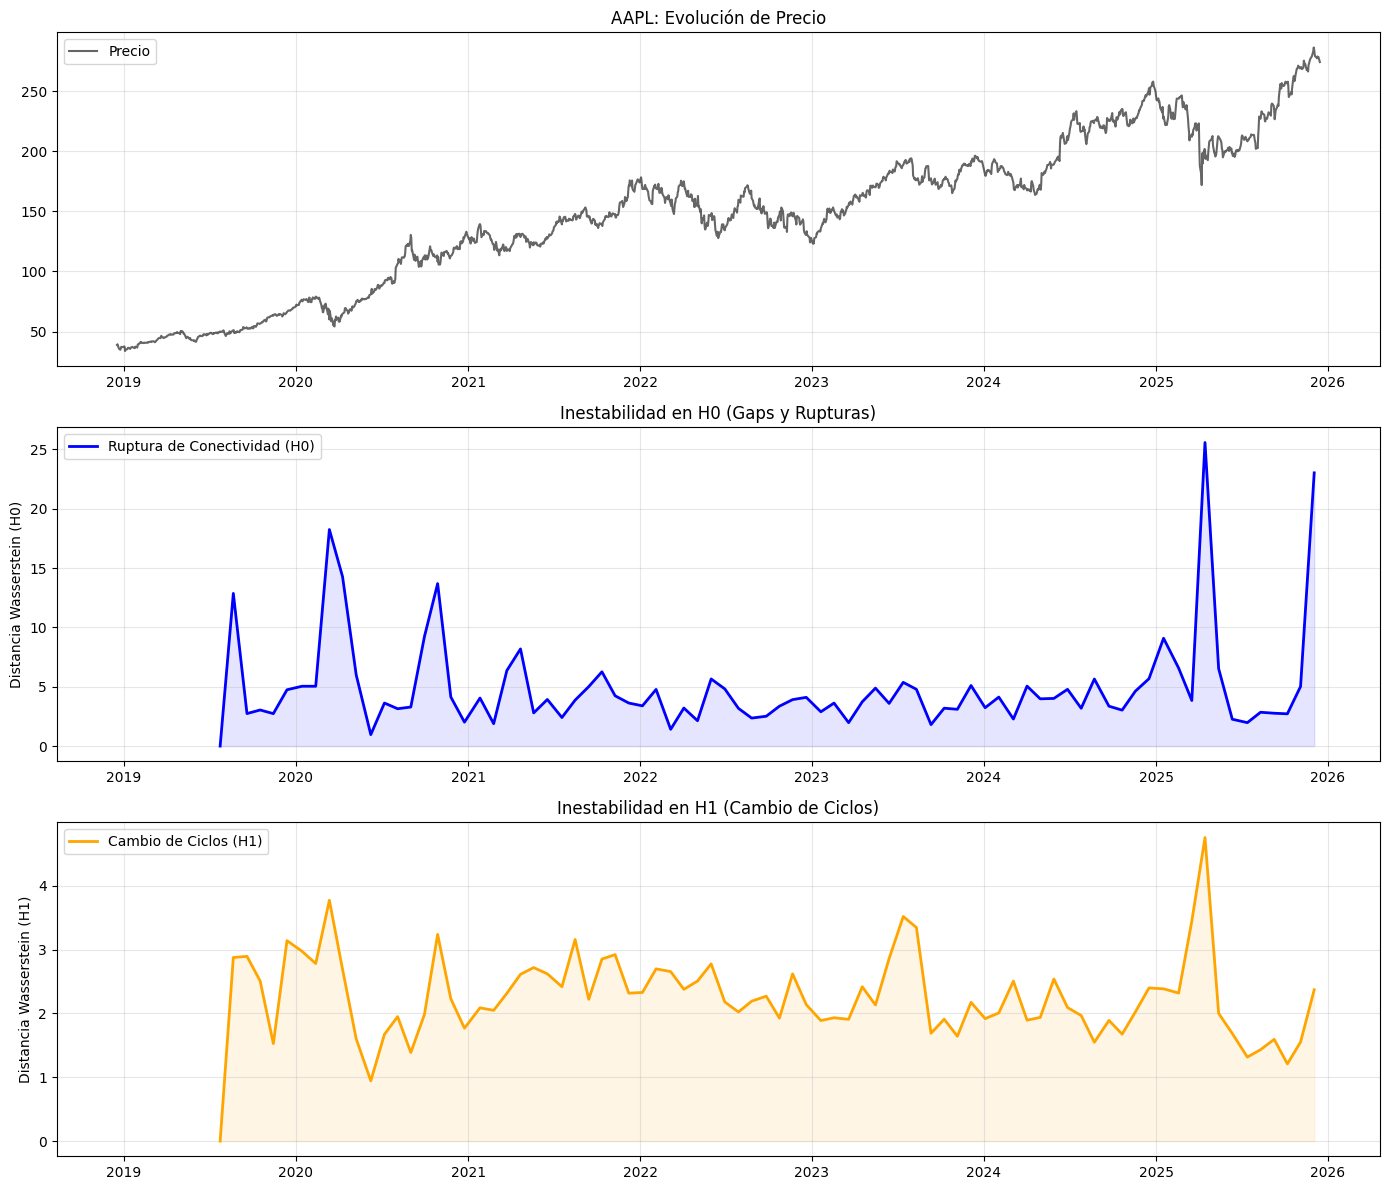

In [ ]:
analyze_market_dynamics("AAPL", period="7y", w_size=150, step=20)

Luego probamos una ventana de 200 días.

 Se generaron 78 ventanas completas de 200 días.


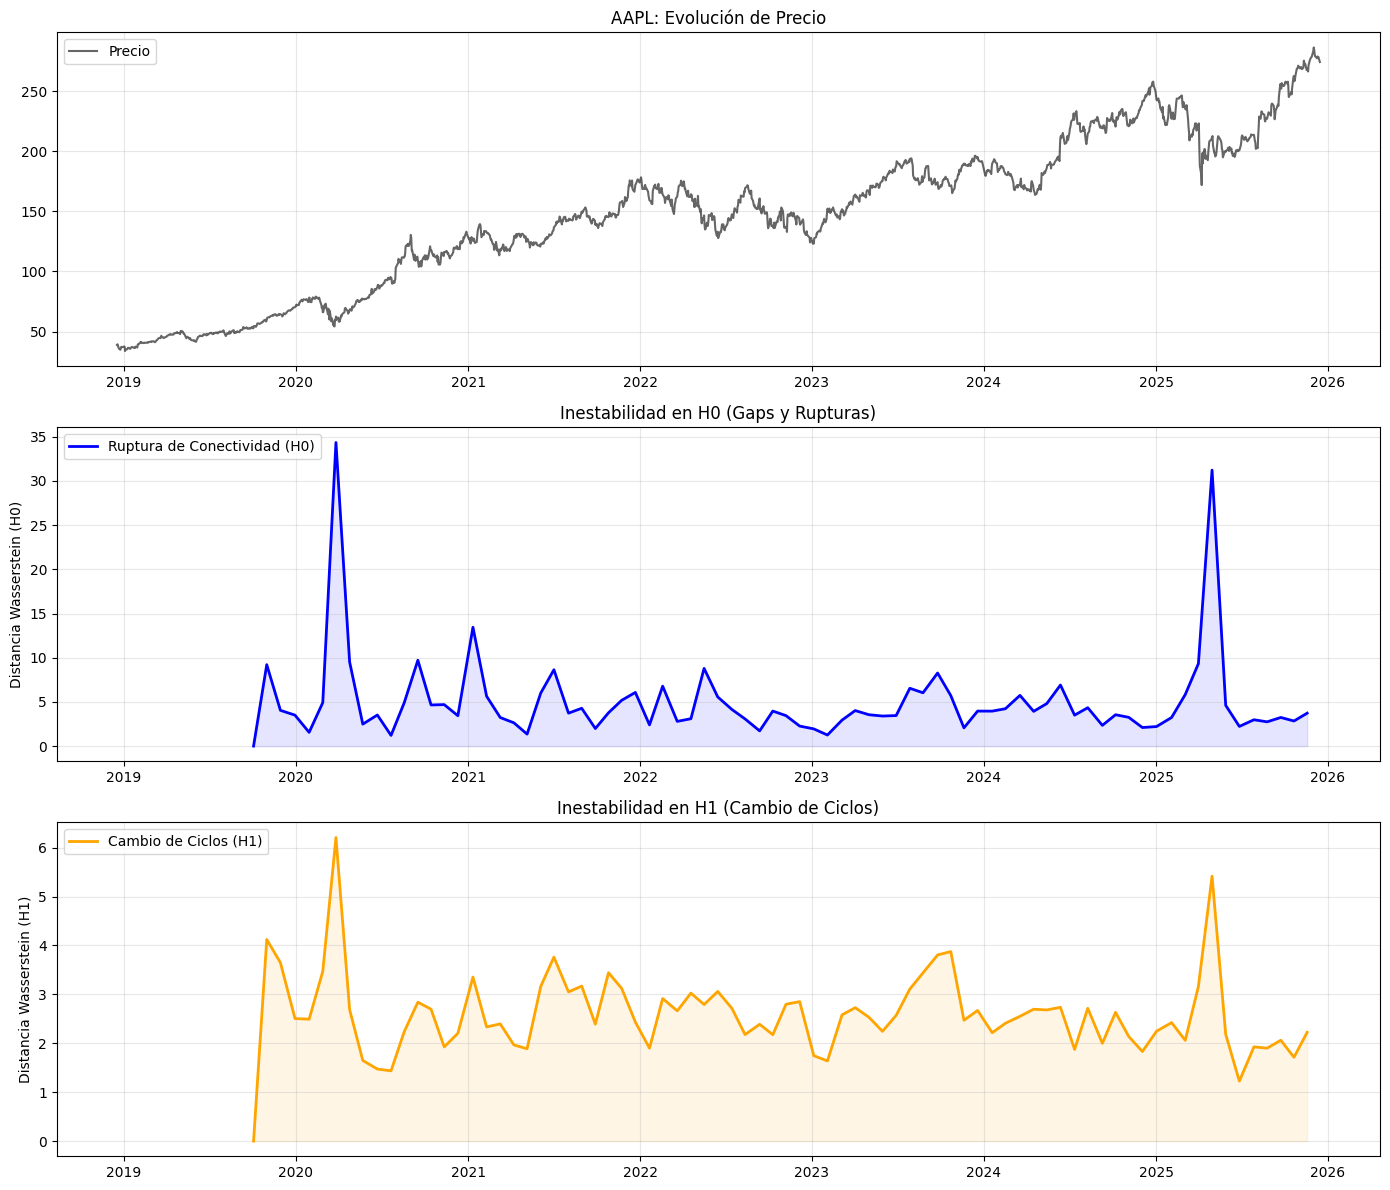

In [ ]:
analyze_market_dynamics("AAPL", period="7y", w_size=200, step=20)

# Interpretación de Resultados: Topología del Mercado

### 1. Sensibilidad de la Ventana Temporal

La elección del tamaño de la ventana determina cuál es el pico más alto de  la crisis que detectamos:

| Ventana | Ganador (Evento) | Qué detecta mejor | Diagnóstico Financiero |
| :--- | :--- | :--- | :--- |
| 150 días (Corta) | 2025 (Aranceles) | Shock Agudo | Detecta la velocidad y violencia inmediata de una noticia sorpresa.  |
| 200 días (Larga) | 2020 (COVID) | Daño Sistémico | Detecta la profundidad y duración de una crisis económica real. |

El evento de 2025 fue más violento en el instante inicial (mayor aceleración de caída), pero el evento de 2020 fue estructuralmente más grave (mayor dispersión total de precios durante el tiempo).

---

### 2. Lectura de Curvas

La Curva Azul ($H_0$) representa la ruptura de conectividad.
* En topología, $H_0$ mide "componentes conectadas". En finanzas, mide si el precio de mañana sigue conectado al de hoy.
* Nivel Bajo (cerca de 0) = fluidez. El mercado tiene continuidad, los precios cambian con poca volatilidad.
* Picos Gigantes = ruptura. El mercado se "rompe". Indica la aparición de gaps (saltos) tan violentos que desconectan la serie temporal.

A partir de esto podemos formular que las crisis financieras agudas son, matemáticamente, rupturas de conectividad.

La Curva Naranja ($H_1$) representa cambios en los ciclos.
* En topología, $H_1$ mide "agujeros" o bucles. En finanzas, mide la "forma" de la oscilación (ritmo de subida/bajada).
* Nivel Estable: el mercado oscila al mismo ritmo (tendencia suave o rango lateral).
* Picos Moderados = cambio de Estrategia. No necesariamente hay pánico, pero la onda cambia de forma (ej. de rápido a lento, o de lateral a tendencia).

---

### 3. Conclusiones

| Señal Visual | Diagnóstico | Interpretación |
| :--- | :--- | :--- |
| Solo Pico AZUL ($H_0$) | CRASH | El mercado está roto, hay desconexión. (Ej: marzo 2020 y abril 2025). |
| Solo Pico NARANJA ($H_1$) | CAMBIO DE RÉGIMEN | Cambio estructural ordenado, inicia una nueva tendencia o cambia la volatilidad, pero sin rotura. |
| AMBOS Picos | CRISIS COMPLEJA | El mercado colapsó y además cambió su forma de moverse para el futuro. |

El análisis mediante TDA no solo confirmó el evento del COVID, sino que también nos permitió detectar otra crisis financiera: https://criptotendencia.com/2025/04/08/apple-se-desploma-pierde-casi-usd-640-000-millones-en-solo-tres-dias/


Según los registros de mercado, Apple sufrió una fuerte caida en el valor de sus acciones, aproximadamente USD 640.000 millones en apenas 72 horas. Este movimiento representa una de las destrucciones de valor más rápidas en la historia corporativa.

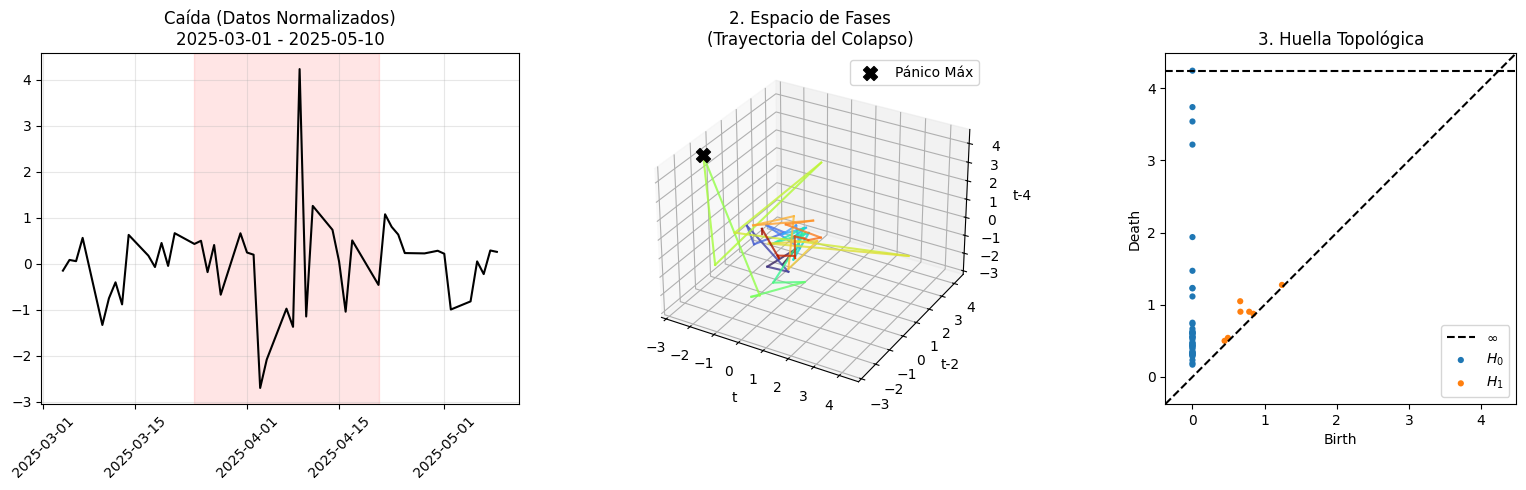

In [ ]:
def analyze_april_crash_only(symbol="AAPL"):
    # Usamos un rango que capture la caída y el rebote (Marzo-Mayo 2025)
    start_date = "2025-03-01"
    end_date = "2025-05-10"

    w, dates = get_window_data(symbol, start_date, end_date)

    DIM = 3
    DELAY = 2

    emb = takens_embedding(w, dim=DIM, delay=DELAY)
    dgms = compute_persistence(emb, maxdim=1)

    fig = plt.figure(figsize=(16, 5))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(dates, w, color='black', linewidth=1.5)

    # Resaltamos visualmente la zona central (abril)
    ax1.axvspan(dates[int(len(dates)*0.3)], dates[int(len(dates)*0.7)], color='red', alpha=0.1)
    ax1.set_title(f"Caída (Datos Normalizados)\n{start_date} - {end_date}")
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)


    ax2 = fig.add_subplot(1, 3, 2, projection='3d')

    # Coloreamos por tiempo para ver la trayectoria
    num_points = len(emb)
    for i in range(num_points - 1):
        ax2.plot(emb[i:i+2, 0], emb[i:i+2, 1], emb[i:i+2, 2],
                 color=plt.cm.turbo(i/num_points), alpha=0.8, lw=1.5)

    # Marcamos el punto de máxima anomalía (más lejos del centro)
    dists = np.linalg.norm(emb, axis=1)
    max_idx = np.argmax(dists)
    ax2.scatter(emb[max_idx,0], emb[max_idx,1], emb[max_idx,2], color='black', s=100, marker='X', label='Pánico Máx')

    ax2.set_title("2. Espacio de Fases\n(Trayectoria del Colapso)")
    ax2.set_xlabel('t')
    ax2.set_ylabel('t-2')
    ax2.set_zlabel('t-4')
    ax2.legend()


    ax3 = fig.add_subplot(1, 3, 3)
    plot_diagrams(dgms, ax=ax3)
    ax3.set_title("3. Huella Topológica")

    plt.tight_layout()
    plt.show()


# --- EJECUTAR ---
analyze_april_crash_only("AAPL")


A diferencia de crisis anteriores que mostraron un deterioro progresivo (como el inicio habitual de un mercado bajista), el modelo TDA identificó que este crash rompió un estado previo de calma absoluta.
   * Antes del evento: la volatilidad era mínima y la topología mostraba ciclos estables (conectividad alta).
   * Durante el evento: el precio no osciló, sino que sufrió una discontinuidad abrupta. La ruptura de conectividad ($H_0$) fue máxima porque el mercado pasó de una "volatilidad topológica cero" a "infinito" instantáneamente.

# Machine Learning

El Análisis Topológico de Datos es especialmente potente en el contexto de Machine Learning porque actúa como un mecanismo de reducción de dimensionalidad. Permite transformar el caos de miles de observaciones de precios en un conjunto muy reducido de descriptores numéricos que capturan la forma global de la dinámica del mercado.

El enfoque general es el siguiente. En lugar de entrenar un modelo de aprendizaje automático directamente sobre precios crudos, que son altamente ruidosos y no estacionarios, se le proporciona información sobre la geometría del mercado. Cada ventana temporal se transforma en un pequeño vector de características topológicas. Por ejemplo:

- Máxima persistencia en $H_0$: mide la ruptura de conectividad y actúa como un indicador directo de pánico.
- Máxima persistencia en $H_1$: cuantifica la fuerza de los ciclos y la estructura oscilatoria del mercado.
- Entropía de persistencia: evalúa cuán ordenado o disperso es el diagrama de persistencia.
- Distancia de Wasserstein respecto a la ventana anterior: captura la velocidad de cambio geométrico entre regímenes consecutivos.

Estas variables resumen la geometría del mercado de forma robusta al ruido y con muy baja dimensionalidad.

Estos resúmenes topológicos condensan información sobre conectividad, ciclos y volatilidad de forma robusta frente al ruido. A partir de ellos, se puede aplicar un algoritmo de detección de anomalías para identificar ventanas cuya geometría no es compatible con el comportamiento histórico normal del mercado.

De este modo, el modelo no busca patrones locales en los precios, sino cambios estructurales en la forma de la dinámica, lo que resulta particularmente adecuado para detectar crisis, transiciones de régimen y eventos extremos.

# Enfoque 1: Clasificación de Regímenes

Objetivo: entrenar un modelo supervisado que clasifique el estado del mercado en tres regímenes discretos: Calma, Alerta y Pánico.

Variables de entrada (features): en lugar de utilizar precios crudos se emplean descriptores topológicos extraídos de cada ventana temporal.

Variable objetivo (etiqueta): es necesario definir una etiqueta “verdadera” para cada ventana. Por ejemplo, una ventana puede etiquetarse como Pánico si el precio cae más de un 5 % en los siguientes 5 días, Alerta para caídas intermedias, y Calma en ausencia de movimientos extremos.


Este enfoque produciría un sistema de decisión explícito e interpretable, similar a un semáforo de mercado, capaz de traducir patrones topológicos en señales operativas. Sin embargo, NO adoptamos este enfoque porque requiere un proceso manual y costoso de etiquetado de ventanas, además de un conocimiento profundo de análisis de mercado para definir correctamente los regímenes. Esta dependencia de etiquetas subjetivas reduce su escalabilidad y capacidad de generalización.


# Enfoque 2: Detección de Anomalías

Objetivo: usar aprendizaje no supervisado (Isolation Forest) para detectar eventos raros del mercado sin necesidad de etiquetarlos previamente.

La idea central es dejar que el modelo aprenda qué es “normal” en la geometría del mercado. Todo lo que se aparte significativamente de esa normalidad será marcado como una anomalía.

---

## ¿Cómo funciona este enfoque?

Se alimenta al modelo con la información topológica del mercado a lo largo de varios años. A partir de estos datos, el algoritmo aprende cuál es la geometría típica del mercado de Apple en condiciones normales.

Cuando aparece un evento extremo (por ejemplo, abril de 2025, crash por aranceles), la topología resultante es tan distinta de la habitual que el modelo la identifica inmediatamente como una anomalía.


#Ingeniería de Características Topológicas

En esta fase, transformamos la serie temporal bruta de precios en una matriz de características topológicas. El objetivo es convertir la "forma" abstracta del mercado en un vector numérico de 9 dimensiones que los algoritmos de Machine Learning puedan interpretar.

Utilizamos una ventana deslizante de 150 días con un paso de 3 días para generar un análisis de alta resolución. Para cada ventana, extraemos tres tipos de métricas:

### Métricas Estáticas
Describen la complejidad geométrica actual del mercado mediante Homología Persistente:
* $H_0$ (Conectividad/Pánico):
    * `H0 Max`: vida de la ruptura más grande. Indica la severidad de un crash agudo.
    * `H0 Sum`: suma total de persistencia. Indica la fragilidad general del sistema.
* $H_1$ (Ciclos/Estructura):
    * `H1 Max`: vida del ciclo más dominante. Indica la fuerza de la tendencia o estacionalidad.
    * `H1 Sum`: cantidad total de estructura cíclica.

### Métricas Dinámicas
Estas son las variables más predictivas. Calculamos la Distancia de Wasserstein entre el diagrama de la ventana actual ($t$) y la anterior ($t-1$).
* `Vel H0` y `Vel H1`: representan la velocidad de cambio. Un pico en estas variables indica que la estructura del mercado ha sufrido una deformación violenta e instantánea, incluso si el precio no ha caído drásticamente todavía.

### Variable de Control
* `Volatilidad`: desviación estándar clásica. Se incluye para que el modelo pueda distinguir entre cambios topológicos genuinos y simple varianza de precios.

Normalizamos todas las variables resultantes utilizando `StandardScaler` para asegurar que las métricas topológicas (que pueden tener escalas muy distintas) tengan el mismo peso durante el proceso de clustering y detección de anomalías.

In [ ]:
windows, dates = load_financial_windows("AAPL", period="max", window_size=200, step=15)
#aumentamos el step (crucial para Wasserstein). Si la ventana es de 1 a 3 días, la diferencia topológica es casi puro ruido numérico.
#Al comparar la topología de hoy contra la de hace 15 días, le damos tiempo al mercado para que desarrolle un cambio estructural real. El Wasserstein detectará tendencias, no temblores.

features = []
valid_indices = []

prev_dgm_h0 = None
prev_dgm_h1 = None

for i, w in enumerate(windows):
    # A. Takens
    emb = takens_embedding(w, dim=3, delay=2)
    if len(emb) == 0: continue

    # B. Diagramas
    dgms = compute_persistence(emb, maxdim=1)
    dgm_h0 = np.array(dgms[0][:-1])
    dgm_h1 = np.array(dgms[1])

    # C. Métricas Estáticas
    if len(dgm_h0) > 0:
        h0_max = np.max(dgm_h0[:, 1])
        h0_sum = np.sum(dgm_h0[:, 1])
    else:
        h0_max, h0_sum, h0_ent = 0, 0

    if len(dgm_h1) > 0:
        lives = dgm_h1[:, 1] - dgm_h1[:, 0]
        h1_max = np.max(lives)
        h1_sum = np.sum(lives)
    else:
        h1_max, h1_sum, h1_ent = 0, 0

    # D. Métricas Dinámicas
    if prev_dgm_h1 is not None:
        try:
            d1_curr = dgm_h1 if len(dgm_h1) > 0 else np.zeros((0,2))
            d1_prev = prev_dgm_h1 if len(prev_dgm_h1) > 0 else np.zeros((0,2))
            wass_dist_h1 = wasserstein(d1_prev, d1_curr)

            d0_curr = dgm_h0 if len(dgm_h0) > 0 else np.zeros((0,2))
            d0_prev = prev_dgm_h0 if len(prev_dgm_h0) > 0 else np.zeros((0,2))
            wass_dist_h0 = wasserstein(d0_prev, d0_curr)
        except:
            wass_dist_h1, wass_dist_h0 = 0, 0
    else:
        wass_dist_h1, wass_dist_h0 = 0, 0

    prev_dgm_h0 = dgm_h0
    prev_dgm_h1 = dgm_h1

    # E. Volatilidad
    volatility = np.std(w)

    features.append([h0_max, h0_sum, h1_max, h1_sum, wass_dist_h0, wass_dist_h1, volatility])
    valid_indices.append(i)

# Matriz Final
X = np.array(features)
feature_names = ['H0 Max', 'H0 Sum', 'H1 Max', 'H1 Sum', 'Vel H0', 'Vel H1', 'Volatilidad']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Matriz de Features Lista: {X.shape}")

# Ajustamos fechas para graficar
dates_plot = [dates[i] for i in valid_indices]


 Se generaron 743 ventanas completas de 200 días.
Matriz de Features Lista: (743, 7)


#Detección de Anomalías y Monitor de Crisis

El objetivo ahora es traducir la matriz de características topológicas $X$ en una decisión binaria de riesgo y visualizarla de manera clara.

## Isolation Forest
Utilizamos un algoritmo de aprendizaje no supervisado diseñado específicamente para detectar outliers:
* `contamination=0.05`: asumimos a priori que el 5% de la historia financiera corresponde a eventos extremos. Esta decisión se alinea con los estándares de Gestión de Riesgos Financieros (VaR 95%), asumiendo a priori que los eventos de inestabilidad estructural severa representan aproximadamente el 5% de la muestra histórica.
* `decision_function`: genera un puntaje de anomalía. Invertimos el signo (`-1 * score`) para que la lógica sea intuitiva: Mayor altura = Mayor Riesgo.

## Suavizado de Señal
Aplicamos una Media Móvil (`rolling mean`) de 6 ventanas sobre el puntaje crudo.
* Objetivo: eliminar el "ruido de microestructura" diario.
* Resultado: convierte picos aislados y nerviosos en tendencias de riesgo estructural claras y legibles.

## Visualización (Monitor de Crisis)
* Línea Verde: representa el Riesgo Estructural suavizado.
* Línea Naranja (Umbral): calculada dinámicamente con el percentil 95 de los datos desde 2019. separa el "ruido normal" del "peligro real". El umbral de alerta visual se fija en el percentil 85 de los puntajes de anomalía suavizados, para poder detectar otras bajadas además de las crisis sistémicas (como COVID-19).
* Área Roja: e activa solo cuando el riesgo supera el umbral, indicando visualmente la duración y profundidad de la crisis.

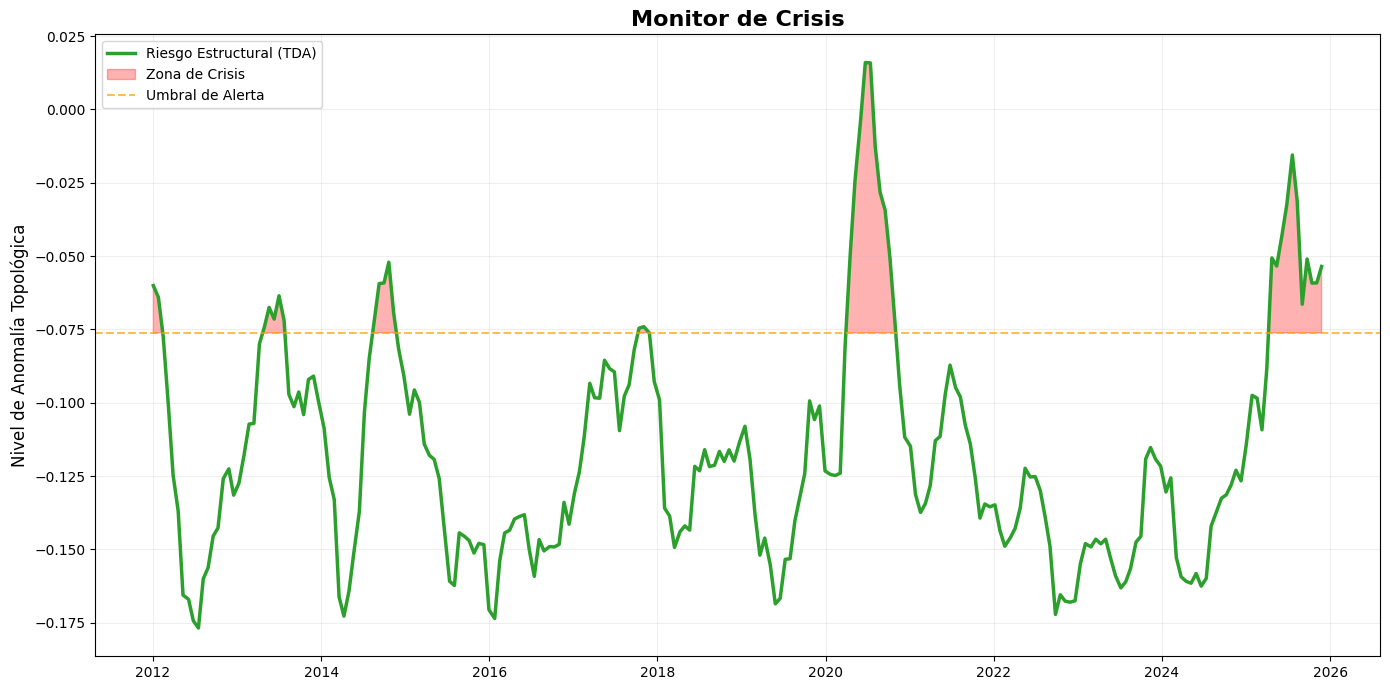

In [ ]:
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_scaled)

anomaly_scores = model.decision_function(X_scaled)
scores_inverted = -1 * anomaly_scores

df_res = pd.DataFrame({
    'Date': dates_plot,
    'Score': scores_inverted
})
df_res.set_index('Date', inplace=True)

# Suavizado
df_res['Score_Smooth'] = df_res['Score'].rolling(window=6).mean()

# Zoom (2012 en adelante)
df_zoom = df_res[df_res.index > "2012-01-01"]
threshold = df_zoom['Score_Smooth'].quantile(0.85)

# Gráfico
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_zoom.index, df_zoom['Score_Smooth'], color='#2ca02c', linewidth=2.5, label='Riesgo Estructural (TDA)')

ax.fill_between(df_zoom.index, df_zoom['Score_Smooth'], threshold,
                where=(df_zoom['Score_Smooth'] >= threshold),
                interpolate=True, color='red', alpha=0.3, label='Zona de Crisis')

ax.axhline(threshold, color='orange', linestyle='--', alpha=0.7, label='Umbral de Alerta')

ax.set_title("Monitor de Crisis", fontsize=16, fontweight='bold')
ax.set_ylabel("Nivel de Anomalía Topológica", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

El gráfico muestra que el TDA es capaz de distinguir la "Calidad" de la crisis.

Las correcciones de mercado normales (2015, 2018) generan alertas moderadas.

Los colapsos sistémicos (2020, 2025) generan alertas extremas.

#Caracterización de Regímenes (Clustering No Supervisado)

Mientras que Isolation Forest se enfoca en detectar "alertas", este bloque busca descubrir y clasificar los diferentes estados estructurales (regímenes) por los que transita el activo a lo largo de la historia, sin necesidad de etiquetas previas.

## Reducción de Dimensiones (PCA)
Dado que nuestra matriz de características $X$ tiene 7 dimensiones, es imposible visualizarla directamente. Utilizamos PCA (Análisis de Componentes Principales) para proyectar esta información compleja en un mapa 2D, preservando la mayor cantidad de varianza posible.
* Eje X/Y: No representan una variable física directa, sino combinaciones lineales de las características topológicas (ej. una mezcla de Pánico y Velocidad).

### Clasificación Automática (K-Means)
Aplicamos el algoritmo K-Means para agrupar los días en 3 clusters o "familias" naturales, basándonos en su similitud geométrica:
1.  Cluster de Calma: se espera baja persistencia y baja velocidad de cambio.
2.  Cluster de Transición/Ruido: valores intermedios.
3.  Cluster de Crisis: se espera alta persistencia ($H_0$ Max alto) y alta velocidad de deformación (Wasserstein alto).

### Interpretación de Resultados
El código genera dos visualizaciones y una tabla:
1.  Mapa de Regímenes (Izquierda): muestra la "geografía" del mercado. Puntos cercanos tienen topología similar. Los centroides marcan el comportamiento arquetípico de cada régimen.
2.  Evolución Temporal (Derecha): un "código de barras" que muestra cómo el mercado salta de un estado a otro en el tiempo.
3.  Tabla de Centroides: muestra el promedio de cada variable para cada cluster. Esta tabla es fundamental para ponerle nombre a los grupos (ej. "El Cluster 2 es la Crisis porque tiene el Max H0 más alto").

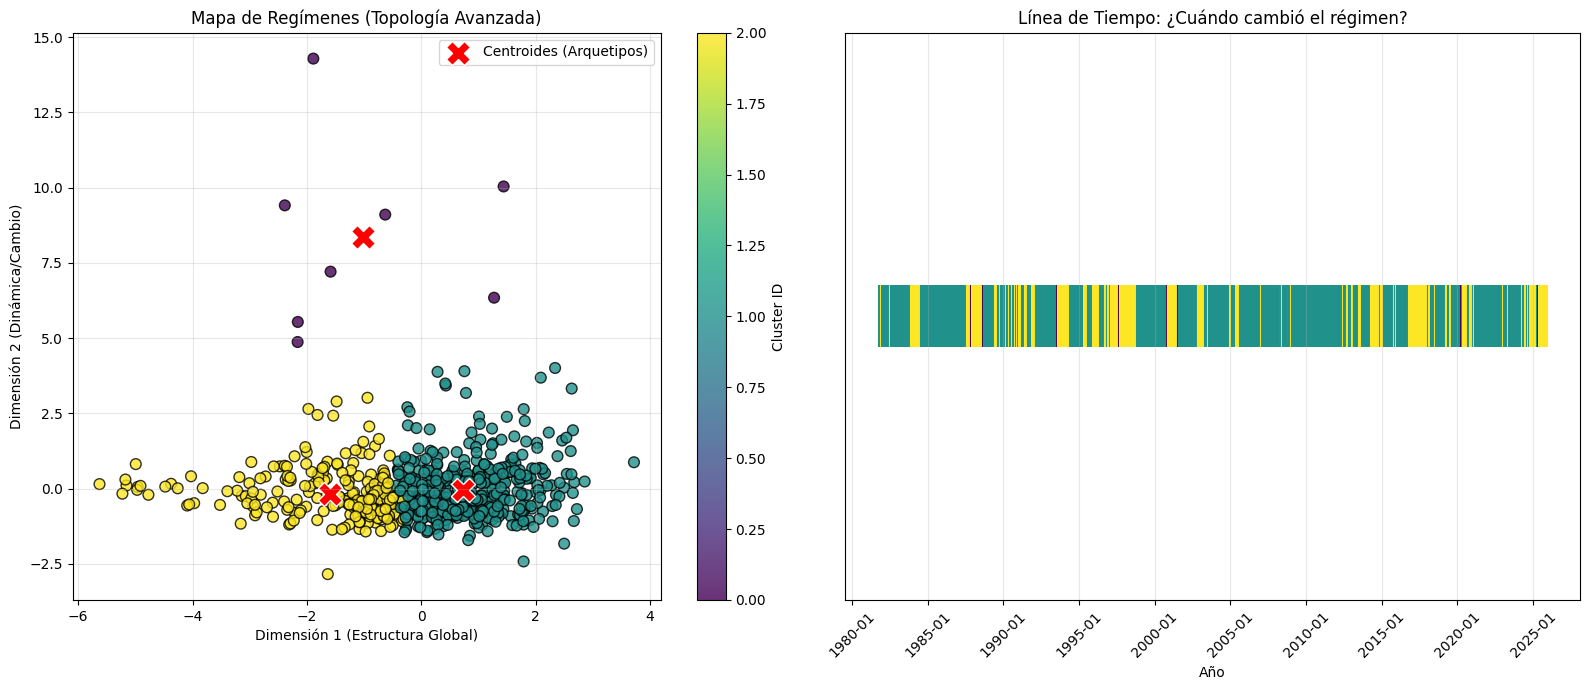


   INTERPRETACIÓN DE LOS CLUSTERS (CARACTERÍSTICAS PROMEDIO)
Cluster              0          1          2
H0 Max        5.311766   2.256553   3.766192
H0 Sum       90.250036  94.451185  92.977569
H1 Max        0.275204   0.393147   0.320382
H1 Sum        5.133347   7.294269   5.624352
Vel H0       31.648244   3.766396   3.424404
Vel H1        4.743169   2.490660   1.825970
Volatilidad   1.000000   1.000000   1.000000


In [ ]:
# Reducción a 2D (PCA) - Para dibujar el mapa
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering (K-Means) - Buscamos 3 estados naturales
# 0: Probable Calma
# 1: Probable Transición/Ruido
# 2: Probable Crisis
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Recorte de seguridad por si falla algún índice
min_len = min(len(dates_plot), len(clusters))
dates_plot = dates_plot[:min_len]
clusters_plot = clusters[:min_len]
X_pca_plot = X_pca[:min_len]

# --- 3. VISUALIZACIÓN ---
fig = plt.figure(figsize=(16, 7))

# GRÁFICO A: EL MAPA DE ESTADOS (PCA)
ax1 = fig.add_subplot(1, 2, 1)
scatter = ax1.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], c=clusters_plot, cmap='viridis', s=60, alpha=0.8, edgecolors='k')

# Pintar los Centroides (Los "Arquetipos")
centers_pca = pca.transform(kmeans.cluster_centers_)
ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=300, marker='X', label='Centroides (Arquetipos)', edgecolors='white')

ax1.set_title("Mapa de Regímenes (Topología Avanzada)")
ax1.set_xlabel("Dimensión 1 (Estructura Global)")
ax1.set_ylabel("Dimensión 2 (Dinámica/Cambio)")
plt.colorbar(scatter, ax=ax1, label='Cluster ID')
ax1.legend()
ax1.grid(True, alpha=0.3)

# GRÁFICO B: LA EVOLUCIÓN TEMPORAL
ax2 = fig.add_subplot(1, 2, 2)
# Scatter "código de barras"
ax2.scatter(dates_plot, [1]*len(dates_plot), c=clusters_plot, cmap='viridis', marker='|', s=2000)

ax2.set_title("Línea de Tiempo: ¿Cuándo cambió el régimen?")
ax2.set_yticks([])
ax2.set_xlabel("Año")
ax2.grid(axis='x', alpha=0.3)

# Forzar formato de fecha legible en eje X
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# --- 4. INTERPRETACIÓN DE LOS GRUPOS (LA TABLA DE LA VERDAD) ---
print("\n" + "="*60)
print("   INTERPRETACIÓN DE LOS CLUSTERS (CARACTERÍSTICAS PROMEDIO)")
print("="*60)

# Creamos DF con las columnas correctas
df_clusters = pd.DataFrame(X[:min_len], columns=feature_names)
df_clusters['Cluster'] = clusters_plot

# Agrupamos y mostramos.
# Transponemos (.T) para que sea más fácil de leer verticalmente
print(df_clusters.groupby('Cluster').mean().T)

#Interpretación de Resultados
El análisis de clustering no supervisado (K-Means) segmenta la historia del activo en  regímenes estructurales distintos, validando la hipótesis de que las crisis financieras poseen una "huella digital" topológica única.

A partir de la tabla de centroides y los gráficos generados, identificamos los siguientes estados:

### Cluster 0: "Shock Sistémico" (CRISIS)
* Corresponde al grupo color violeta en el mapa.
* Características Clave:
    * Velocidad Explosiva: ss el rasgo más distintivo. La variable `Vel H0` (Velocidad de cambio en $H_0$) es de 31.64, casi 10 veces superior a la de los otros clusters (~3.5).
    * Alta Desconexión: posee el `H0 Max` más alto (5.31), indicando fracturas severas en la conectividad del mercado.
* Conclusión: este régimen no representa una simple caída de precios, sino un cambio de fase instantáneo y violento. El mercado se "rompe" y se reconfigura en cuestión de días (COVID-19, Crash 2025).

### Cluster 1: "Estabilidad / Calma" (NORMALIDAD)
* Corresponde al grupo color verde agua.
* Características Clave:
    * Mínima Persistencia: tiene el `H0 Max` más bajo de todos (2.25).
    * Estructura Solida: los componentes conectados son estables y hay poca actividad anómala.
* Conclusión: representa el estado base del mercado, donde la volatilidad es ruido blanco y no hay amenazas estructurales.

### Cluster 2: "Transición / Corrección" (INCERTIDUMBRE)
* Corresponde al grupo color amarillo.
* Características Clave:
    * Valores Intermedios: su `H0 Max` (3.76) es alto, similar al de la crisis, pero su velocidad es baja (3.42).
* Conclusión: representa periodos donde el mercado "sufre" (caídas de precio, Bear Markets lentos), pero no colapsa estructuralmente a gran velocidad. Diferencia geométricamente una "corrección sana" de un "crash sistémico".

---
La Topología de Datos (TDA) demuestra que las crisis financieras (Cluster 0) son matemáticamente distinguibles de las correcciones estándar (Cluster 2) principalmente por la velocidad de deformación (Wasserstein) y no solo por la magnitud de la caída.